In [436]:
%matplotlib inline
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import gdal
from rasterstats import zonal_stats
from sklearn.decomposition import PCA
import pickle
import seaborn as sns
# sns.set_style("whitegrid")
sns.set_context('notebook')
# sns.set_style("ticks")

##CLASSIFICATION

In [2]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from pylab import *
from scipy.ndimage import measurements

In [3]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
#your code here
def cv_optimize(clf, parameters, X, y, n_jobs=-1,n_folds=5, score_func=None):
    
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best



In [4]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=-1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func, n_jobs=n_jobs)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

###Load the data

We  start by working with two different data sets:
- **Full data**: contains the 11 bands from Landsat, Corona data, SRTM data and the sites (response variable)
- **PCA data**: contains the two principal components obtained from the Landsat PCA, Corona data, SRTM data and the sites.
The idea of using PCA is to reduce the size of the data and thus the computational time and costs of running the classification.

We will test with both data sets and analyze the results considering running time and obtained recall for the test set.
After doing this we will choose the data set that has the better performance in both of these aspects and we will keep doing the analysis with it.

####Full data

In [303]:
#We load the other images (corona, SRTM and the sites)
corona = np.load('../../corona.npy')
srtm = np.load('../../srtm.npy')
sites_matrix = np.load('../../sites.npy')
bands_matrix = np.load('../../landsat.npy')
rows = sites_matrix.shape[0]
cols = sites_matrix.shape[1]
sites = sites_matrix.flatten().astype(int)

In [304]:
#We create a dataframe with the data
columns = ['B1','B10','B11','B2','B3','B4','B5','B6','B7','B8','B9', 'corona','srtm','sites']
indexi=xrange(len(corona))
df = pd.DataFrame(columns=columns,  index=indexi)
df['corona']=corona
df['srtm']=srtm
df['sites']= sites
df['B1'] = bands_matrix[:,0]
df['B10'] = bands_matrix[:,1]
df['B11'] = bands_matrix[:,2]
df['B2'] = bands_matrix[:,3]
df['B3'] = bands_matrix[:,4]
df['B4'] = bands_matrix[:,5]
df['B5'] = bands_matrix[:,6]
df['B6'] = bands_matrix[:,7]
df['B7'] = bands_matrix[:,8]
df['B8'] = bands_matrix[:,9]
df['B9'] = bands_matrix[:,10]

In [305]:
df.head()

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9,corona,srtm,sites
0,11280,41223,37826,10961,11097,12338,15287,16982,15094,11750,5050,151,469,0
1,11319,41281,37818,10984,11179,12585,15126,17091,15307,11708,5061,143,469,0
2,11258,41274,37743,10866,11098,12189,15634,16895,15083,11490,5046,152,469,0
3,11231,41109,37561,10850,11055,12351,15076,16907,15209,11598,5045,151,469,0
4,11222,40726,37146,10919,11208,12643,15381,17307,15584,11850,5039,155,469,0


In [ ]:
#We save the dataframe
#pd.to_pickle(df,'DfStandardized.pkl') 

In [367]:
#We load the dataframe
df = pickle.load(open('DfStandardized.pkl','rb'))

####PCA data

In [ ]:
#We load the principal components obtained from the PCA
PCA_first_component= pickle.load(open('PCA_no_QA.pk','rb'))
PCA_second_component= pickle.load(open('PCA_no_QA_2ndComponent.pk','rb'))
PCA_first_component = PCA_first_component.flatten()
PCA_second_component =PCA_second_component.flatten()

In [ ]:
#We create a data frame with the data
columns_PCA = ['Landsat_PCA1','Landsat_PCA2', 'corona','srtm','sites']
indexi=xrange(len(corona))
df_PCA = pd.DataFrame(columns=columns_PCA,  index=indexi)
df_PCA['Landsat_PCA1'] = PCA_first_component
df_PCA['Landsat_PCA2'] = PCA_second_component
df_PCA['corona']=corona
df_PCA['srtm']=srtm
df_PCA['sites']= sites
df_PCA.head()

In [364]:
#We save the dataframe
#pd.to_pickle(df_PCA,'Df_PCA.pkl') 

In [ ]:
#We load the dataframe
df_PCA = pickle.load(open('Df_PCA.pkl','rb'))

###Divide training and testing set

In [9]:
# Create test/train mask. We use the same mask for both data sets so so the models can be fairly compared
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)

mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [11]:
# make sure we didn't get unlucky in our mask selection
print "% Sites in Training:", np.mean(df.sites[mask])
print "% Sites in Testing:", np.mean(df.sites[~mask])

% Sites in Training: 0.0594092643765
% Sites in Testing: 0.0593449791032


###Standardize the data

####Full data

In [67]:
#We use the mask to compute the training and test parts of the dataframe.  
#We standarize the explanatory variables and replace them in th training set. 
featurenames = list(df.columns[:-1])

training = df[mask]
test = df[~mask]

STANDARDIZABLE = featurenames
params = StandardScaler().fit(training[STANDARDIZABLE])
df[STANDARDIZABLE] = StandardScaler().fit_transform(df[STANDARDIZABLE], params)

In [192]:
#We save the standardization parameters
pickle.dump(params, open('Standardize_params.pk', 'wb'))

####PCA data

In [ ]:
#We use the mask to compute the training and test parts of the dataframe.  
#We standarize the explanatory variables and replace them in th training set. 
featurenames_PCA = list(df_PCA.columns[:-1])

training_PCA = df_PCA[mask]
test_PCA = df_PCA[~mask]

STANDARDIZABLE = featurenames_PCA
params_PCA = StandardScaler().fit(training_PCA[STANDARDIZABLE])
df_PCA[STANDARDIZABLE] = StandardScaler().fit_transform(df_PCA[STANDARDIZABLE], params_PCA)

###Balance the data in the training set

####Full data

In [362]:
#We get the training and test sets
featurenames = list(df.columns[:-1])

targetname = 'sites'
target1val =1 

subdf=df[featurenames]
X=subdf.values
y=(df[targetname].values==target1val)*1
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

In [13]:
#Let's check the amount of positives and negatives responses in our training set
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

523124 8282304


####PCA data

In [ ]:
#We get the training and test sets
featurenames_PCA = list(df_PCA.columns[:-1])

targetname = 'sites'
target1val =1 

subdf=df_PCA[featurenames_PCA]
X=subdf.values
y=(df_PCA[targetname].values==target1val)*1
Xtrain_PCA, Xtest_PCA, ytrain_PCA, ytest_PCA = X[mask], X[~mask], y[mask], y[~mask]

In [356]:
#Let's check the amount of positives and negatives responses in our training set
jtrain_PCA=np.arange(0, ytrain_PCA.shape[0])
n_pos=len(jtrain_PCA[ytrain_PCA==1])
n_neg=len(jtrain_PCA[ytrain_PCA==0])
print n_pos, n_neg

523124 8282304


There are many more negative samples in the training set. We want to balance the negative samples to the positive samples. So lets sample n+ samples from the negative samples in the training set (without replacement).

####Full data

In [14]:
#We use the same sampling for both data sets so the models can be fairly compared
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [15]:
#We concatenate all the indexes and use them to select a new training set from the old one.
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(1046248,)

In [16]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((1046248, 13), (1046248,))

In [17]:
#We store these into a new split variable reuse_split_new.
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

###PCA data

In [ ]:
#We concatenate all the indexes and use them to select a new training set from the old one.
alli=np.concatenate((jtrain_PCA[ytrain==1], ineg))
alli.shape

In [ ]:
Xtrain_PCA_new = Xtrain_PCA[alli]
ytrain_PCA_new = ytrain_PCA[alli]
Xtrain_PCA_new.shape, ytrain_PCA_new.shape

In [ ]:
#We store these into a new split variable reuse_split_new.
reuse_split_PCA_new=dict(Xtrain=Xtrain_PCA_new, Xtest=Xtest_PCA, ytrain=ytrain_PCA_new, ytest=ytest_PCA)

##Random Forest

Since the data set is heavily unbalanced, accuracy is not the right score for evaluating the model performance.Instead, we use recall. $$\text{Recall} = \frac{TP}{TP+FN}$$

This metric is more relevant for our purposes.  In practical terms, false positives are not very problematic because it does not take a lot of effort to identify a falsely identified site, but false negatives are troublesome because we may lose the opportunity to find an invaluable archaeological site.  Therefore we wish to maximize the proportion of sites that are correctly recognized, and accept that this choice may result in a high rate of false positives.

####Full data

In [363]:
#We run a cross validation for finding the best RF model, we variate the number of features to consider when looking 
#for the best split:
clfForest = RandomForestClassifier(n_estimators=38)
parameters = {"max_features": range(3, 13)}

clfForest,  _,_,_,_ = do_classify(clfForest, parameters, 
                                  df, featurenames, 'sites', 1, reuse_split=reuse_split_new, score_func='recall' )


using reuse split
BEST {'max_features': 4} 0.436931509574 [mean: 0.43437, std: 0.15057, params: {'max_features': 3}, mean: 0.43693, std: 0.15146, params: {'max_features': 4}, mean: 0.43603, std: 0.15143, params: {'max_features': 5}, mean: 0.43615, std: 0.15146, params: {'max_features': 6}, mean: 0.43584, std: 0.15113, params: {'max_features': 7}, mean: 0.43568, std: 0.15097, params: {'max_features': 8}, mean: 0.43660, std: 0.15158, params: {'max_features': 9}, mean: 0.43606, std: 0.15085, params: {'max_features': 10}, mean: 0.43645, std: 0.14996, params: {'max_features': 11}, mean: 0.43599, std: 0.15018, params: {'max_features': 12}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.83
[[4611859  909807]
 [  85688  262932]]
########################################################


In [30]:
#We save the resulting model and the mask
pickle.dump([clfForest, mask], open('clfForest_mask.pk', 'wb'))

In [369]:
#We calculate the recall for the test set
%time
Xpredictions = clfForest.predict(Xtest)
recall = recall_score(ytest, Xpredictions, labels=None, pos_label=1, average='binary', sample_weight=None)
print recall

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 16.9 µs
0.753042724444


In [348]:
#We run a cross validation for finding the best RF model, we variate the number of features to consider when looking 
#for the best split:
clfForest_PCA = RandomForestClassifier(n_estimators=38)
parameters = {"max_features": range(2, 5)}

clfForest_PCA,  _,_,_,_ = do_classify(clfForest_PCA, parameters, 
                                  df_PCA, featurenames_PCA, 'sites', 1, reuse_split=reuse_split_PCA_new, score_func='recall' )


using reuse split
BEST {'max_features': 4} 0.259276959191 [mean: 0.25549, std: 0.06950, params: {'max_features': 2}, mean: 0.25877, std: 0.07004, params: {'max_features': 3}, mean: 0.25928, std: 0.06971, params: {'max_features': 4}]
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.64
[[3526385 1995529]
 [ 126441  221931]]
########################################################


In [ ]:
#We save the resulting model and the mask
pickle.dump([clfForest_PCA, mask], open('clfForest_mask_PCA.pk', 'wb'))

In [368]:
#We calculate the recall for the test set 
%time
Xpredictions_PCA = clfForest_PCA.predict(Xtest_PCA)
recall_PCA = recall_score(ytest_PCA, Xpredictions_PCA, labels=None, pos_label=1, average='binary', sample_weight=None)
print recall_PCA

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 19.1 µs
0.637051772243


As we can see the model trained on the full data has a higher recall value (0.75 versus 0.63) and similar run time than the model trained on the PCA data. Consequently, from now on **we will use the full data set** and the Random Forest trained on that data for the rest of our analysis.

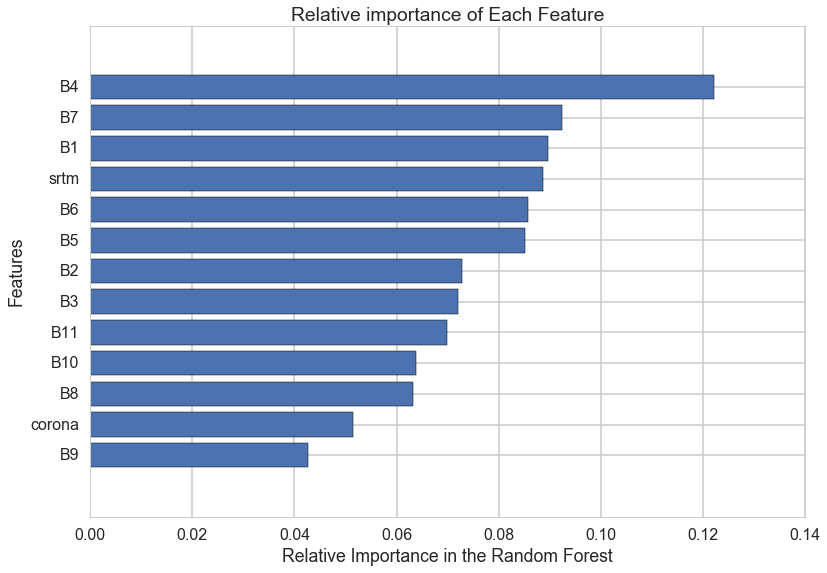

In [191]:
#We look at the feature importances of our chosen classifier
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.savefig('Feature_importance.png')

We can see in the figure that the most relevant features for the classification are B4 and B7. This is not suprising since these two Landsat bands are moisture indicators (based on the vegetation). Sites tend to have different moisture that the surrounding landscape. On the other hand, the lest explanatory variables are B8 and B9. These correspond to thermal bands. It is interesting to see that they are not so relevant for the classification since people have been using them for years for detecting archeological sites.

Finally, it is also surprising that the Corona images have such a low importance. Corona images are usually used to identify sites by eye. One possible explanation for this is that the Corona pixels were aggregated from very fine resolution and a lot of the detail in these images was lost in the process.

In [10]:
#We load the classifier and the mask
[clfForest, mask] = pickle.load(open('clfForest_mask.pk','rb'))

##Results analysis

We reshape the test set and our predictions and plot them in the map.

In [21]:
#We reshape the y variable
ytest_matrix = np.zeros((rows*cols,))
ytest_matrix[~mask] = ytest
ytest_matrix = ytest_matrix.reshape((rows,cols))

In [22]:
#We reshape the X variables
Xpredictions = clfForest.predict(Xtest)
Xpredictions_matrix = np.zeros((rows*cols,))
Xpredictions_matrix[~mask] = Xpredictions
Xpredictions_matrix = Xpredictions_matrix.reshape((rows,cols))

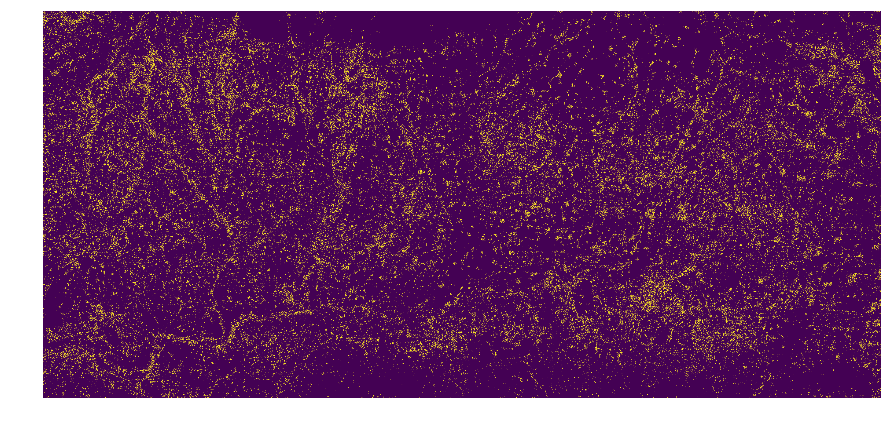

In [453]:
#Let's take a look at our predictions
plt.figure(figsize=(15,18))
plt.imshow(Xpredictions_matrix, cmap="viridis")
plt.axis('off')
plt.savefig("Predictions.png",bbox_inches='tight')

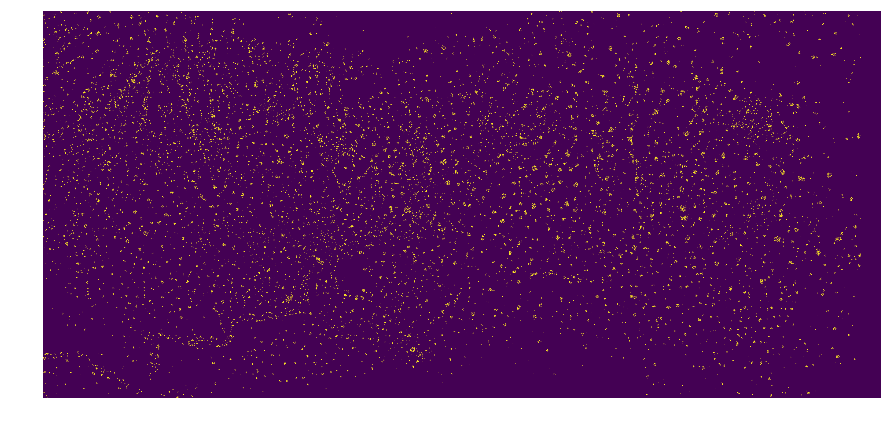

In [454]:
#Now let's take a look at the real sites
plt.figure(figsize=(15,18))
plt.imshow(ytest_matrix, cmap="viridis")
plt.axis('off')
plt.savefig("Sites.png",bbox_inches='tight')

We create a matrix that represents TP, FP, and FN with different values. For display purposes, we combine the TN with the out-of-test negatives to make the image less noisy.

- TN or Out of test negative: 0

- Out of test positive: 1

- FN: 11

- FP: 20

- TP: 31

In [23]:
full_matrix = sites_matrix + 10*ytest_matrix+ 20*Xpredictions_matrix

In [115]:
#We save the matrix
np.save('./full_matrix.npy', full_matrix)

In [24]:
#We select a small area of the matrix to plot
full_matrix_corner = full_matrix[1500:1700,1500:1700]
full_matrix_corner = full_matrix_corner[::-1]

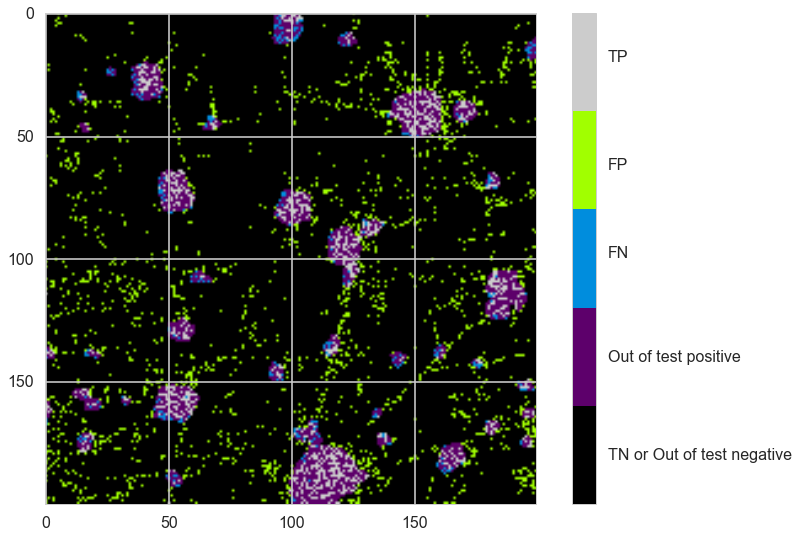

In [26]:
from matplotlib import colors
cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72], cmaplist[164],cmaplist[255]]) #cmaplist[164]
bounds=np.array([0,1,11,20,31,40])
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(full_matrix_corner , cmap=cmap, norm=norm)

cbar = plt.colorbar(ticks=[0.5,6,16,25,36])
cbar.ax.set_yticklabels(['TN or Out of test negative', 'Out of test positive', 'FN','FP','TP'])  

# plt.savefig("Predicted_map.png",bbox_inches='tight')

We can see in the figure that most of the sites contain correctly identified pixels. It is very interesting to notice that there are a lot of FP but they seem to follow a pattern, possibly ancient roads connecting the sites. We will analyze this possibility [further](#Why-so-many-FP?) in this notebook.

In [164]:
#We plot the confusion matrix, in particular we care about the FN. We want that number to be as small as possible.
conf = confusion_matrix(ytest, Xpredictions)
conf

array([[4616426,  905488],
       [  86033,  262339]])

In [155]:
#We also calculate the accuracy (eventhough this is not the metric we really take in consideration)
accuracy_score(ytest, Xpredictions)

0.83109494154117869

In [165]:
#False discovery rate
conf[0,1]/float(conf[0,1]+conf[1,1])

0.77536141911430378

We realize that we still have a lot of FN in our results. In practical terms, if we flag any of the pixels within a site, we have discovered the full site because the full extent of a site is obvious to a ground observer. 

Thus, to have a visual idea of our performance (check how many sites we actually detected), we consider that if a pixel within a site is flagged, then the whole site is discovered (thus it takes the value of a TP). 

To do so we search for each TP its surrounding neighbors and flag them as detected if they belong to the site (we assign them the TP value). We repeat this few iterations, the idea is to mark all the pixels of the site as discovered.

To be clear, this cannot be used for the real prediction (since in that case we do not have the location of the sites). We do it just to have an idea of the proportions of sites in our test set that we can consider discovered by our method.

In [27]:
#We create a matrix with the following values:
# 1 for a site pixel that was not flagged (either because it is a FN or because it was not in the test set)
# 0 for a pixel that is not a site and was not flagged 
# -9 for a TP
# -10 for a FP

TPneighbors = sites_matrix - 10 * Xpredictions_matrix

In [28]:
#We iteratively look at each TP and flag its neighbors as TP in case they belong to a site and that they were not
#considered as TP before. In other words we transform all the 1 surrounding a -9 into -9.

def find_neighbors(TPneighbors,rows,cols,iterations=10):
    for i in range(iterations):
        print i
        for row in range(rows):
            for column in range(cols):
                if TPneighbors[row,column] == -9:
                    cmin = np.maximum(column-1,0)
                    cmax = np.minimum(column+1,cols-1)
                    rmin =  np.maximum(row-1,0)
                    rmax = np.minimum(row+1,rows-1)

                    if TPneighbors[row,cmin] == 1:
                        TPneighbors[row,cmin] = -9
                    elif TPneighbors[row,cmax] == 1:
                        TPneighbors[row,cmax] = -9
                    elif TPneighbors[rmin ,column] == 1:
                        TPneighbors[rmin ,column] = -9
                    elif TPneighbors[rmin ,cmin] == 1:
                        TPneighbors[rmin ,cmin] = -9
                    elif TPneighbors[rmin ,cmax] == 1:
                        TPneighbors[rmin ,cmax] = -9
                    elif TPneighbors[rmax,column] == 1 :
                        TPneighbors[rmax,column] = -9
                    elif TPneighbors[rmax,cmin] == 1:
                        TPneighbors[rmax,cmin] = -9
                    elif TPneighbors[rmax,cmax] == 1:
                        TPneighbors[rmax,cmax] = -9
    return TPneighbors

In [29]:
#We find all the FN that were converted to TP

TPneighbors = find_neighbors(TPneighbors,rows,cols,iterations=10)

new_TP = np.zeros((rows,cols))
new_TP[TPneighbors==-9]=1

new_TP2 = np.zeros((rows*cols))
new_TP2[~mask] = new_TP.flatten()[~mask]
new_TP2 = new_TP2.reshape((rows,cols))

temp = sites_matrix - 10 * Xpredictions_matrix

original_TP = np.zeros((rows,cols))
original_TP[temp==-9]=1
original_TP2 = np.zeros((rows*cols))
original_TP2[~mask] = original_TP.flatten()[~mask]
original_TP2 = original_TP2.reshape((rows,cols))

new_TP2 = -(original_TP2 - new_TP2)

0
1
2
3
4
5
6
7
8
9


In order to visualize the new TP we create a matrix that represents TP, New TP, FP, and FN with different values. For display purposes, we combine the TN with the out-of-test negatives to make the image less noisy.
- TN or Out of test negative: 0
- Out of test positive:1
- FN:11
- FP:20
- TP:31
- New TP:51

In [30]:
full_matrix3 = sites_matrix + 10*ytest_matrix+ 20*Xpredictions_matrix + 40*new_TP2

In [31]:
#We select the same small area of the matrix and plot it so we can compare it
full_matrix3_corner = full_matrix3[1500:1700,1500:1700]
full_matrix3_corner = full_matrix3_corner[::-1]

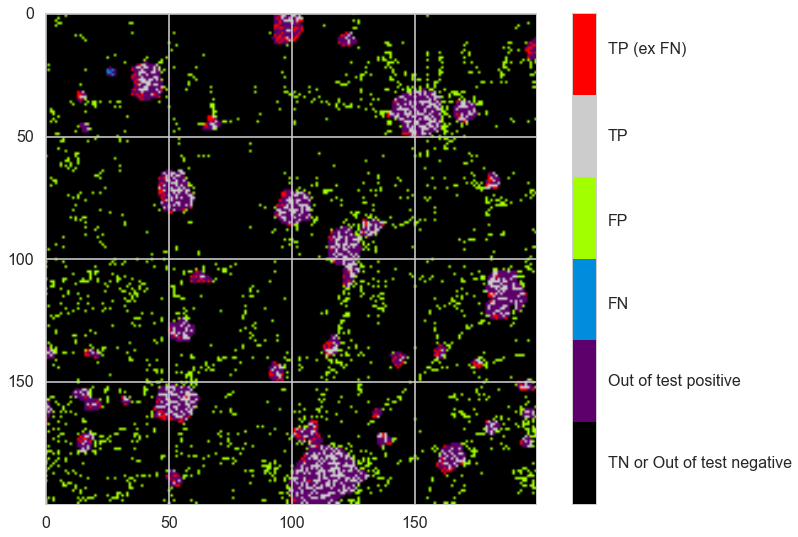

In [32]:
cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72],cmaplist[164],cmaplist[255],'red']) #cmaplist[164]
bounds=np.array([0,1,11,20,31,51,60])

norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(full_matrix3_corner, cmap=cmap, norm=norm)

cbar = plt.colorbar(ticks=[0.5,6,15,25,41,56])
cbar.ax.set_yticklabels(['TN or Out of test negative','Out of test positive','FN','FP','TP','TP (ex FN)'])  

# plt.savefig("Predicted_neighbors_map.png",bbox_inches='tight')

In [139]:
#We calculate the proportion of FN that were converted to FP
(len(np.where(full_matrix==11)[0])-len(np.where(full_matrix3==11)[0]))/float(len(np.where(full_matrix==11)[0]))

0.9705578092127439

We can see in the figure how almost all of our previous FN became now TP (red points). There are still some FN (blue points) that were not discovered, we believe this is related to the small size of those sites as it can be seen in the plot (site in the upper left corner). Our hypothesis was rigt: our model identified at least one pixel in almost every site. This is confirmed by the high proportion of converted FN to FP (0.97).

In [33]:
#All the pixels that were not flagged by our model (TN and FN) get values = 0
#All the pixels that were flagged (TP and FP) get values of 1
TPneighbors[TPneighbors==1] = 0
TPneighbors[TPneighbors==-10] = 1
TPneighbors[TPneighbors==-9] = 1

In [34]:
#We flatten the TPneighbors so we can calculate the performance metrics
new_predictions = TPneighbors.flatten()[~mask]

In [211]:
conf = confusion_matrix(ytest, new_predictions)
print conf

[[4616426  905488]
 [   2533  345839]]


In [54]:
accuracy_score(ytest, new_predictions)

0.84531912073789928

In [212]:
#False discovery rate
conf[0,1]/float(conf[0,1]+conf[1,1])

0.72362220266964594

In [213]:
#Recall before neighbors
original_recall = recall_score(ytest, Xpredictions, labels=None, pos_label=1, average='binary', sample_weight=None)

#Recall after neighbors
recall2 = recall_score(ytest, new_predictions, labels=None, pos_label=1, average='binary', sample_weight=None)

print 'Original Recall:', original_recall, 'Recall after looking for neighbors:',recall2

Original Recall: 0.753042724444 Recall after looking for neighbors: 0.992729036777


As we can see the recall increased almost to 100%! This proves again that we are actually discovering at least one pixel per site in our test set. We will have to check later if this would have been equally achieved by using a random prediction.

Since we are not yet convinced that this was not obtained by pure luck, we do another inspection of our results. To do so we run a percolation clustering on our predictions (http://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/). The idea is to flag as a cluster all the points that are directly or indirectly connected to each other. This would be equivalent to setting fire to a forest for revealing which trees are clustered together.

In [132]:
#We apply the percolation clustering to Xpredictions_matrix (original predictions of our model) 

#s is a structuring element that defines the feature connections
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]

#We find the clusters and we label them 
lw, num = measurements.label(Xpredictions_matrix, structure=s)

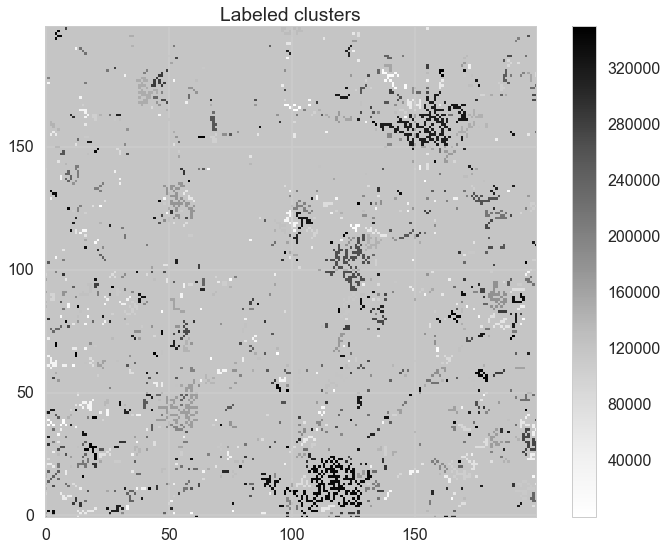

In [134]:
#Beacause the label starts from the bottom up, the cluster colors are a bit too ordered, making it hard to distinguish
#two clusters close to each other. To fix this, we shuffle the labeling:
b = arange(lw.max() + 1) # create an array of values from 0 to lw.max() + 1
shuffle(b) # shuffle this array
shuffledLw = b[lw] # replace all values with values from b
imshow(shuffledLw[1500:1700,1500:1700], origin='lower', interpolation='nearest') # show image clusters as labeled by a shuffled lw
colorbar()
title("Labeled clusters")


As we can see, it is way easier now to see the different clusters. Nevertheless, this could be even clearer.

Lets repeat the previous plot but this time by showing the area of each cluster.

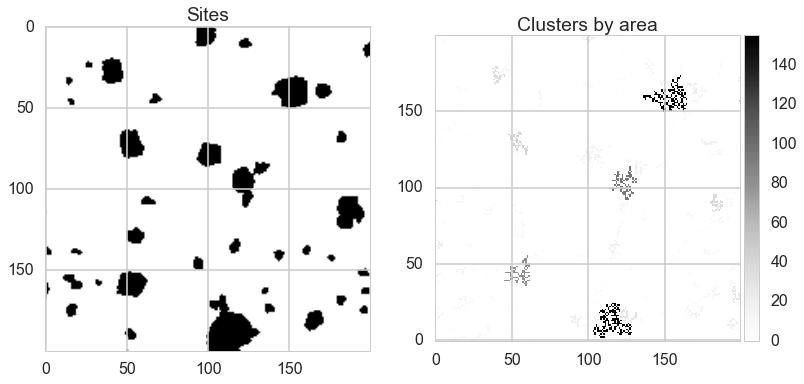

In [294]:
#We plot the same matrix as above, but this time with all clusters colored by area and we compare it to the real sites
# fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2,1)
im1 = imshow(sites_matrix[1500:1700,1500:1700][::-1],aspect=1)
title("Sites")

plt.subplot(1,2,2)
ax = plt.gca()
area = measurements.sum(Xpredictions_matrix, lw, index=arange(lw.max() + 1))
areaImg = area[lw]
im = imshow(areaImg[1500:1700,1500:1700], origin='lower', interpolation='nearest',aspect=1)
title("Clusters by area")


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.subplots_adjust(hspace=4.0)
plt.colorbar(im, cax=cax)

# plt.savefig("Clusters_predicted_compare.png",bbox_inches='tight')

Impressive! We can clearly see that most of the clusters we found match with the sites in our data!
Let's now calculate the performance parameters in the obtained matrix.

In [58]:
#To be able to calculate the new accuracy we need to transform our cluster matrix into a matrix of 0 and 1s. 
#Remember that the clusters have different values depending on their area size, thus we need to decide a threshold.
#Since we prioritize low FNR rather than high FPR we choose a relatively low value for the threshold.

clusters = np.copy(areaImg)
clusters[clusters>=20]=1
clusters[areaImg2<20]=0

In [59]:
accuracy_score(ytest, clusters.flatten()[~mask][::-1])

0.88644352251321312

In [60]:
conf3 = confusion_matrix(ytest, clusters.flatten()[~mask][::-1])
print conf3

[[5180627  341287]
 [ 325322   23050]]


In [61]:
recall_score(ytest, clusters.flatten()[~mask], labels=None, pos_label=1, average='binary', sample_weight=None)

0.4374748831708633

As we can see the accuracy went from 0.831 to 0.886 but the recall decreased from 0.753 to 0.437. This is not surprising, by choosing a threshold equals to 20 we are eliminating some of our TP (that now become FN) and eliminating some FP (that now become TN). If we want to be consistent with the fact that we want as few FN as possible, then this clustering approach must be discarded: the best threshold is actually equal to 1. In other words, anything that has a minimum probability of being a site should be flagged as such.

In any case, the percolation clustering allows us to have a parameter to control the trade-off between FN and TP and to have a cool visualization of the biggest found sites.

##Why so many FP?

As we mentioned earlier, it seems that our FPs follow some kind of pattern. We suspect that these could correspond to ancient roads connecting the cities. If that is the case it would mean that they are actually not FP but ancient areas different from sites! Let's check a portion of our predictions again:

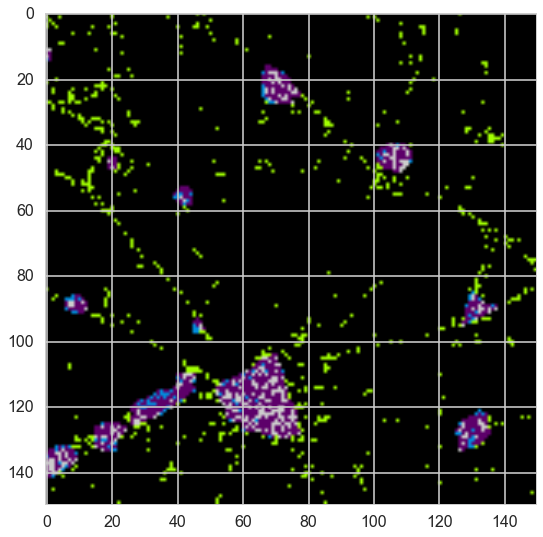

In [387]:
cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72],cmaplist[164],cmaplist[255],'red']) #cmaplist[164]
bounds=np.array([0,1,11,20,31,51,60])

norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(full_matrix[200:350,200:350], cmap=cmap, norm=norm)

Let's use the shortwave infrared band 6 from landsat to check our theory; this band can be used to see the difference between wet earth and dry earth; hollow ways tend to be wetter than surrounding soil.

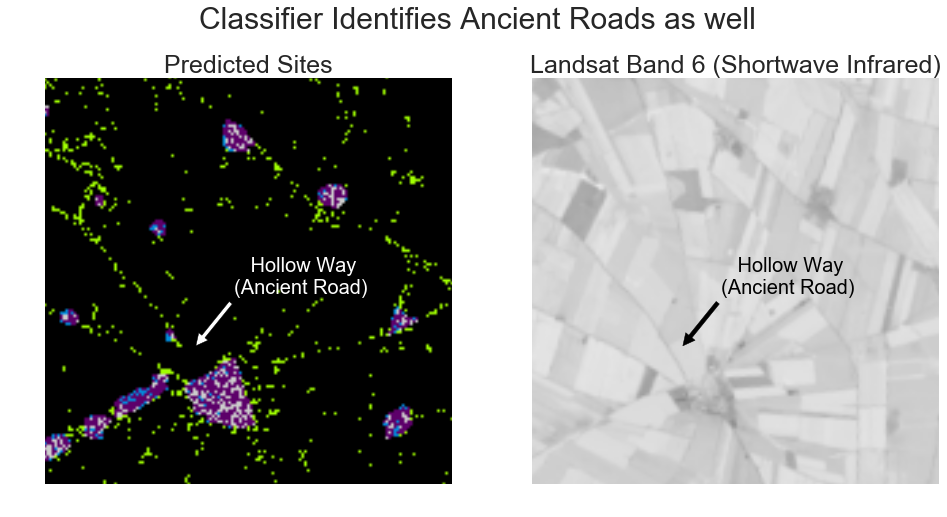

In [388]:
B6_reshaped = df['B6'].values.reshape((rows,cols))

cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72],cmaplist[164],cmaplist[255],'red']) #cmaplist[164]
bounds=np.array([0,1,11,20,31,51,60])

norm = colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(ncols=2, figsize=(16, 16))
fig.suptitle('Classifier Identifies Ancient Roads as well',y=0.75,fontsize=30)
ax0, ax1 = axes

#first plot predicted site map zoomed in to see hollow ways:
ax0.imshow(full_matrix, cmap=cmap, norm=norm)
ax0.set_title('Predicted Sites', fontsize=25)
ax0.set_xlim(200,350)
ax0.set_ylim(350,200)
ax0.annotate('   Hollow Way\n(Ancient Road)', xy=(255, 300), xytext=(270, 280),
            arrowprops=dict(facecolor='white', shrink=0.05), color="white", fontsize=20
            )

#then compare first plot with Landsat image
ax1.imshow(B6_reshaped, cmap = plt.cm.binary)
ax1.set_title('Landsat Band 6 (Shortwave Infrared)', fontsize=25)
ax1.set_xlim(200,350)
ax1.set_ylim(350,200)
ax1.annotate('   Hollow Way\n(Ancient Road)', xy=(255, 300), xytext=(270, 280),
            arrowprops=dict(facecolor='black', shrink=0.05), color="black", fontsize=20
            )

for ax in axes:
    ax.axis('off')

plt.show()

AMAZING! The "patterns" we were talking about correspond indeed to ancient roads! Our model was not failing then when it was returning so many FP since they actually corresponded to ancient features.

Summarizing: although it was not our intention, when we plotted the results of our classifier on a map, we realized that many of our false positives were linear features radiating out from archaeological sites.  While these are not sites, they are certainly important archaeological features.  These features are called "hollow ways", or ancient roadways that were [formed over a long period of time by foot traffic](http://scholar.harvard.edu/jasonur/pages/hollow-ways-1) moving from an archaeological site out to agricultural fields over the course of thousands of years.  This would be an interesting feature to investigate for further research.  If we could isolate and classify these road features, we could automate this procedure over large parts of the Middle East and perform large-scale transportation analyses on our results (that would be impossible without automation).  For the purposes of identifying archaeological sites in our current project, however, we only make strongly clustered results visible, so there is less noise distracting from the archaeological sites.

##Testing our model

As we mentioned earlier we need to make a test to compare our results to a random prediction. To do so we create two types of random predictions: 
- The first one assumes that we do not anything about the general distribution of the sites, so we assign randomly 0s and 1s to the predictions (equivalent to flipping an unbiased coin).
- The second one assumes that we know from our data that sites are rare and that they represent only 6% of the studied area in North Syria. We create our random predictions by assigning 0s with 94% of chances and 1s with 6% (equivalent to flipping a biased coin).

###Unbiased random prediction

In [261]:
#We create totally random predictions 
random_prediction_matrix = np.zeros((rows*cols))
random_prediction = np.random.randint(0,2,len(ytest))

In [262]:
random_prediction_matrix[~mask] = random_prediction
random_prediction_matrix = random_prediction_matrix.reshape((rows,cols))

In [224]:
full_matrix_random_prediction = sites_matrix + 10*ytest_matrix+ 20*random_prediction_matrix

In [227]:
full_matrix_random_prediction_corner = full_matrix_random_prediction[1500:1700,1500:1700]
full_matrix_random_prediction_corner = full_matrix_random_prediction_corner[::-1]

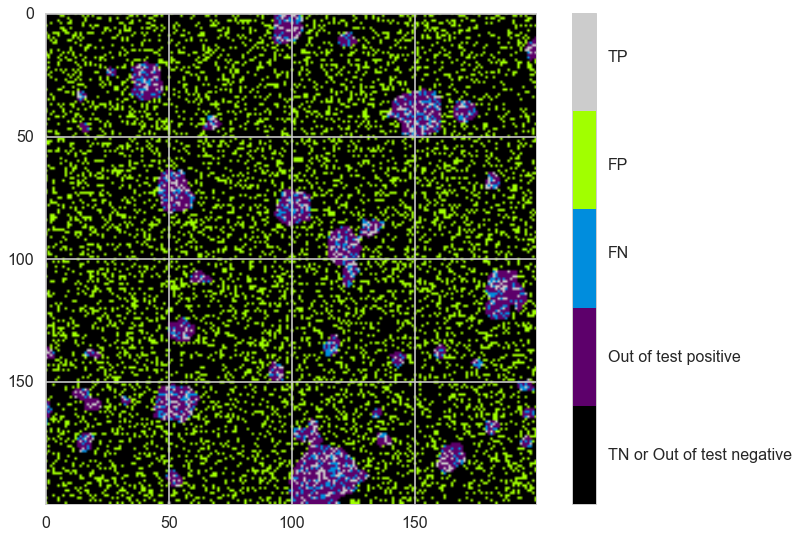

In [256]:
#Let's plot the obtained predictions
cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72], cmaplist[164],cmaplist[255]]) #cmaplist[164]
bounds=np.array([0,1,11,20,31,40])
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(full_matrix_random_prediction_corner , cmap=cmap, norm=norm)


# plt.imshow(bye , cmap='nipy_spectral')
cbar = plt.colorbar(ticks=[0.5,6,16,25,36])
cbar.ax.set_yticklabels(['TN or Out of test negative', 'Out of test positive', 'FN','FP','TP'])  
# cbar.ax.tick_params(axis='x', direction='in')

plt.savefig("Random_prediction_map.png",bbox_inches='tight')

In [229]:
print accuracy_score(ytest, random_prediction_matrix.flatten()[~mask]) 

0.499699673917


In [230]:
conf_test = confusion_matrix(ytest, random_prediction_matrix.flatten()[~mask])
print conf_test

[[2759372 2762542]
 [ 174364  174008]]


In [211]:
#False discovery rate
conf_test[0,1]/float(conf_test[0,1]+conf_test[1,1])

0.94078295839926684

In [231]:
recall_score(ytest, random_prediction_matrix.flatten()[~mask], labels=None, pos_label=1, average='binary', sample_weight=None)

0.49948905193299115

As we could have expected the recall is about 50%. This prediction is evidently worse than what we obtained by using our model ( 75%) and it also has a higher false discovery rate (94% versus 72%). To visualize this better we plot the clusters obtained from the random predictions in the following picture.

In [263]:
#Let's cluster our predictions
lw_test, num_test = measurements.label(random_prediction_matrix, structure=s)

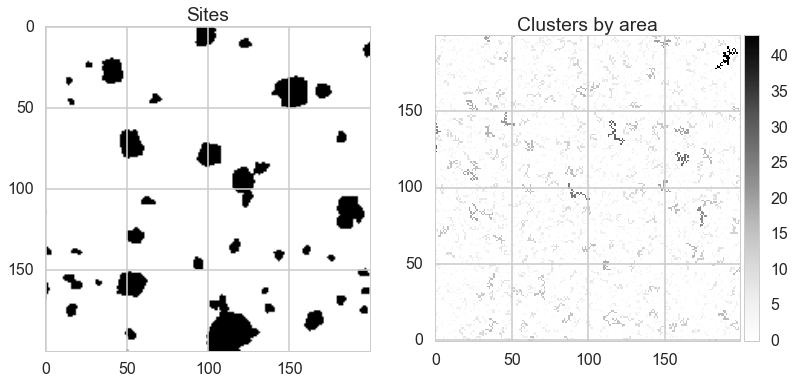

In [264]:
#We compared the real sites to the clustered predictions

plt.subplot(1,2,1)
im1 = imshow(sites_matrix[1500:1700,1500:1700][::-1],aspect=1)
title("Sites")

subplot(1,2,2)
ax = plt.gca()
area_test = measurements.sum(random_prediction_matrix, lw_test, index=arange(lw_test.max() + 1))
areaImg_test = area_test[lw_test]
im = imshow(areaImg_test[1500:1700,1500:1700], origin='lower', interpolation='nearest')
title("Clusters by area")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.subplots_adjust(hspace=4.0)
plt.colorbar(im, cax=cax)


plt.savefig("Random_prediction_clusters.png",bbox_inches='tight')

As we can see the clusters obtained by doing an unbiased random prediction do not match at all with the real sites. It is evident now that our model is better than an unbiased random prediction!

###Biased random prediction

In [285]:
#We create weighted random predictions based on the proportions of negatives and positives in our data set
random_prediction_matrix2 = np.zeros((rows*cols))
proportion = len(np.where(sites)[0])/float(len(sites))
random_prediction2 = np.random.choice(2, len(ytest), replace=True, p=[1-proportion,proportion])

In [273]:
random_prediction_matrix2[~mask] = random_prediction2
random_prediction_matrix2 = random_prediction_matrix2.reshape((rows,cols))

In [274]:
full_matrix_random_prediction2 = sites_matrix + 10*ytest_matrix+ 20*random_prediction_matrix2

In [275]:
full_matrix_random_prediction_corner2 = full_matrix_random_prediction2[1500:1700,1500:1700]
full_matrix_random_prediction_corner2 = full_matrix_random_prediction_corner2[::-1]

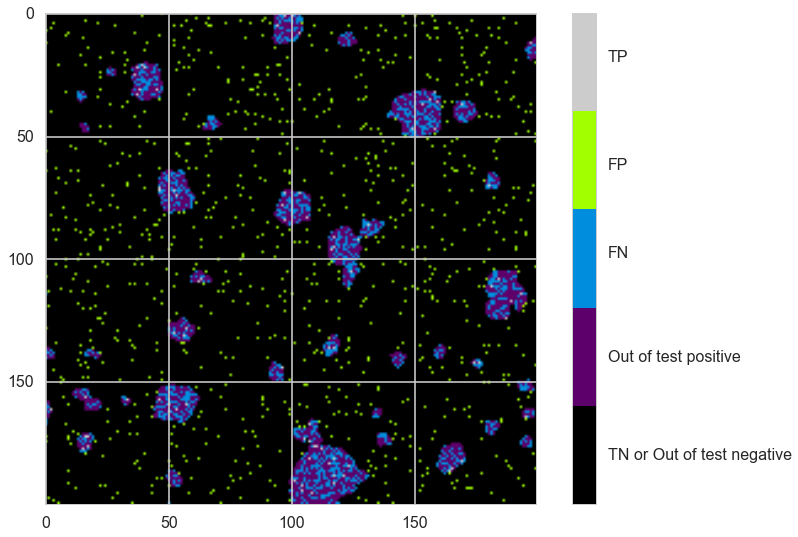

In [276]:
#Let's plot the obtained predictions
cmap = plt.cm.nipy_spectral
cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = colors.ListedColormap([cmaplist[0],cmaplist[10],cmaplist[72], cmaplist[164],cmaplist[255]]) #cmaplist[164]
bounds=np.array([0,1,11,20,31,40])
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(full_matrix_random_prediction_corner2 , cmap=cmap, norm=norm)


# plt.imshow(bye , cmap='nipy_spectral')
cbar = plt.colorbar(ticks=[0.5,6,16,25,36])
cbar.ax.set_yticklabels(['TN or Out of test negative', 'Out of test positive', 'FN','FP','TP'])  
# cbar.ax.tick_params(axis='x', direction='in')

plt.savefig("Random_prediction_map2.png",bbox_inches='tight')

In [277]:
print accuracy_score(ytest, random_prediction_matrix2.flatten()[~mask]) 

0.887787579685


In [249]:
conf_test2 = confusion_matrix(ytest, random_prediction_matrix2.flatten()[~mask])
print conf_test2

[[5191120  330794]
 [ 327647   20725]]


In [251]:
#False discovery rate
conf_test2[0,1]/float(conf_test2[0,1]+conf_test2[1,1])

0.94104159376875784

In [278]:
recall_score(ytest, random_prediction_matrix2.flatten()[~mask], labels=None, pos_label=1, average='binary', sample_weight=None)

0.0594709104061176

For this case the recall is drastically lower than the one obtained for our model (6% versus 75%) and again the false discovery rate is significantly bigger (94% versus 72%).

In [270]:
#Let's cluster our predictions
lw_test2, num_test2 = measurements.label(random_prediction_matrix2, structure=s)

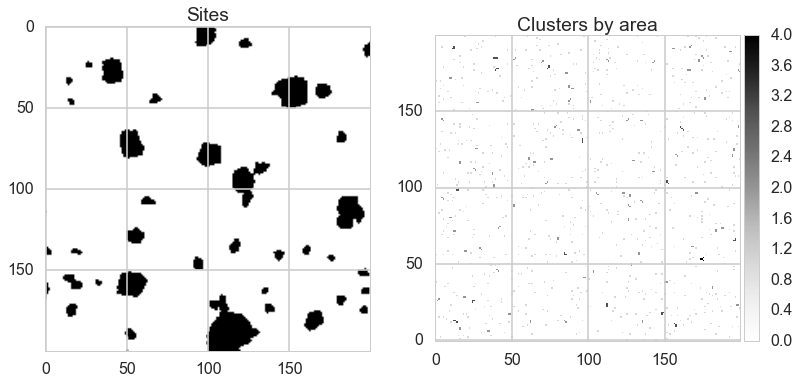

In [271]:
#We compared the real sites to the clustered predictions

plt.subplot(1,2,1)
im1 = imshow(sites_matrix[1500:1700,1500:1700][::-1],aspect=1)
title("Sites")

subplot(1,2,2)
ax = plt.gca()
area_test = measurements.sum(random_prediction_matrix2, lw_test2, index=arange(lw_test2.max() + 1))
areaImg_test = area_test[lw_test2]
im = imshow(areaImg_test[1500:1700,1500:1700], origin='lower', interpolation='nearest')
title("Clusters by area")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.subplots_adjust(hspace=4.0)
plt.colorbar(im, cax=cax)


plt.savefig("Random_prediction_clusters2.png",bbox_inches='tight')

Again we can see how the biased random prediction does not output relevant clusters. Our model keeps being the winner so far!